# Quick Start

## Introduction
In this tutorial, you will get a quick view of `AiiDA-WorkGraph`. To run this tutorial, you need to install `aiida-workgraph`. Open a terminal and run:

```console
pip install aiida-workgraph
```

Start (or restart) the AiiDA daemon if needed:
```console
verdi daemon start
```

Load the AiiDA profile.

In [14]:
%load_ext aiida
from aiida import load_profile
load_profile()

The aiida extension is already loaded. To reload it, use:
  %reload_ext aiida


Profile<uuid='57ccbf7d9e2b41b39edb2bfdaf725feb' name='default'>

## First workflow
Suppose we want to calculate ```(x + y) * z ``` in two steps. First, add `x` and `y`, then multiply the result with `z`.


### Create node
Node is the basic building block of the WorkGraph. A node has inputs, outputs. In AiiDA, one uses the `calcfunction` to do the calculation and generate new data. AiiDA-WorkGraph goes one step further by transforming a `calcfunction` to a `Node`.

In [15]:
from aiida_workgraph import node

# define add node
@node.calcfunction()
def add(x, y):
    return x + y

# define multiply node
@node.calcfunction()
def multiply(x, y):
    return x*y



#### Visualize the node
If you are running in a Jupiter notebook, you can visualize the node by adding the following code to the last line of the cell:

```python
add.node()
```


In [16]:

# export the node to html file so that it can be visualized in a browser
add.node().to_html()

# visualize the node in jupyter-notebook
# add.node()

The input sockets are generated automatically based on the function arguments. The default name of the output socket is `result`. There are also some built-in sockets for all nodes, like `_wait` and `_outputs`.  In case of `calcfunction`, it also has several built-in sockets, such as `metadata`. One can also create a node instance and inpsect its inputs and outputs:

In [17]:
add1 = add.node()
print("Inputs:", add1.inputs.keys())
print("Outputs:", add1.outputs.keys())

Inputs: ['metadata', 'metadata.store_provenance', 'metadata.description', 'metadata.label', 'metadata.call_link_label', 'x', 'y', '_wait']
Outputs: ['result', '_outputs', '_wait']


If you want to change the name of the output sockets, or if there are more than one output. You must define the outputs explicitly.
For example:

In [18]:
# define add calcfunction node
@node.calcfunction(outputs=[["General", "sum"],
               ["General", "difference"]])
def add_minus(x, y):
   return {"sum": x + y, "difference": x - y}

print("Inputs:", add_minus.node().inputs.keys())
print("Outputs:", add_minus.node().outputs.keys())

Inputs: ['metadata', 'metadata.store_provenance', 'metadata.description', 'metadata.label', 'metadata.call_link_label', 'x', 'y', '_wait']
Outputs: ['sum', 'difference', '_outputs', '_wait']


 Each output is defined by two values: e.g. `["General", "sum"]`, where the first value `General` indicates the data type, and the second value is the name of the socket. The data type tell the code how to display the socket in the GUI and to serialize data into database. We use `General` for any data type.

### Create the workflow
Three steps:

- create a empty `WorkGraph`
- add nodes: `add` and `multiply`.
- link the output of the `add` node to one of the `x` input of the `multiply` node.


#### Visualize the workgraph
If you are running in a Jupiter notebook, you can visualize the workgraph by adding the following code to the last line of the cell:

```python
wg
```


In [19]:
from aiida_workgraph import WorkGraph
from aiida.orm import Int

wg = WorkGraph("first_workflow")
wg.nodes.new(add, name="add", x=Int(2.0), y=Int(3.0))
wg.nodes.new(multiply, name="multiply", y=Int(4.0))
wg.links.new(wg.nodes["add"].outputs[0], wg.nodes["multiply"].inputs["x"])

# export the workgraph to html file so that it can be visualized in a browser
wg.to_html()
# visualize the workgraph in jupyter-notebook
# wg

### Submit and view results


In [20]:
wg.submit(wait=True)

print("State of WorkGraph:   {}".format(wg.state))
print('Result of add      : {}'.format(wg.nodes["add"].outputs[0].value))
print('Result of multiply : {}'.format(wg.nodes["multiply"].outputs[0].value))

WorkGraph node created, PK: 49540
State of WorkGraph:   FINISHED
Result of add      : uuid: 3a401f03-6d22-48bb-b5e0-69475e489a85 (pk: 49542) value: 5
Result of multiply : uuid: 29710916-0f13-47c1-9cba-17a17c15b506 (pk: 49544) value: 20


One can also generate the node graph from the AiiDA process:

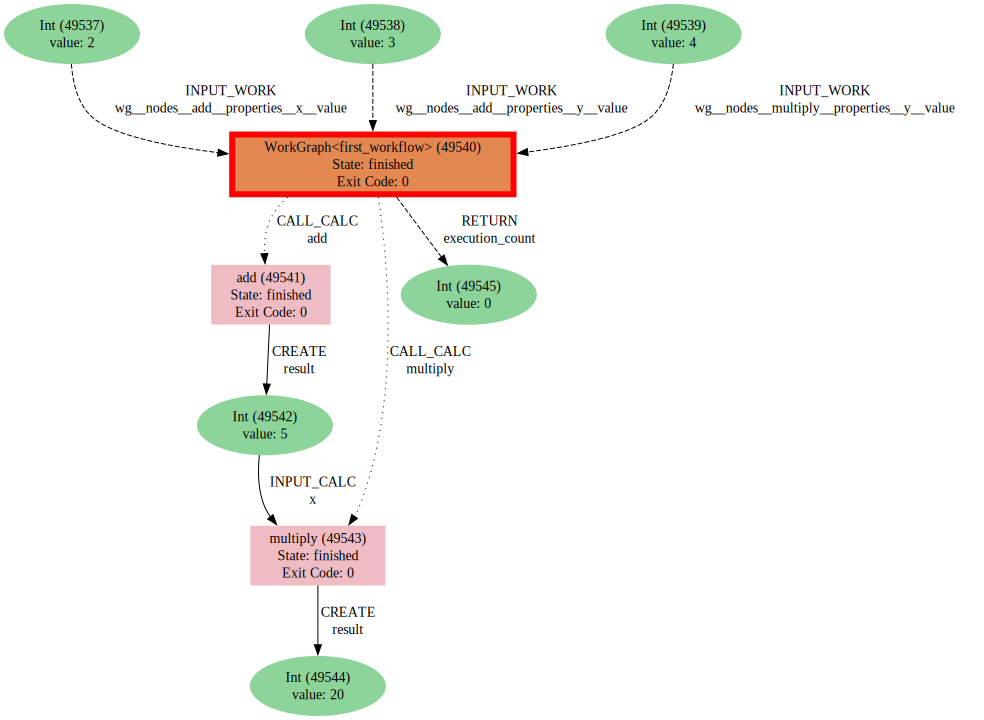

In [21]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)

## Remote job
We set `run_remotely` to `True` when adding the node. This will tell the engine that the job should be run on a remote computer.

In this case, we use define the node using normal function instead of `calcfunction`. Thus, user does not need to install AiiDA on the remote computer.


In [22]:
from aiida_workgraph import WorkGraph, node

# define add node-
@node()
def add(x, y):
    return x + y

# define multiply node
@node()
def multiply(x, y):
    return x*y

wg = WorkGraph("second_workflow")
wg.nodes.new(add, name="add", run_remotely=True)
wg.nodes.new(multiply, name="multiply", x=wg.nodes["add"].outputs[0], run_remotely=True)

# export the workgraph to html file so that it can be visualized in a browser
wg.to_html()
# visualize the workgraph in jupyter-notebook
# wg


### Submit the workgraph

**Code**: We can set the `computer` to the remote computer where we want to run the job. This will create a code `python3@computer` if not exists. Of course, you can also set the `code` directly if you have already created the code.


**Data**: Users can (and is recoomaneded) use normal Python data as input. The workgraph will transfer the data to AiiDA data (`GeneralData`) using pickle.

**Python Version**: since pickle is used to store and load data, the Python version on the remote computer should match the one used in the localhost. One can use conda to create a virtual environment with the same Python version. Then activate the environment before running the script.

```python
# For real applications, one can pass metadata to the scheduler to activate the conda environment
metadata = {
    "options": {
        'custom_scheduler_commands' : 'module load anaconda\nconda activate py3.11\n',
    }
}
```

WorkGraph node created, PK: 49549

Result of multiply is uuid: 11e99e75-871b-440c-a451-68c55ec92f5e (pk: 49563) value: 20 




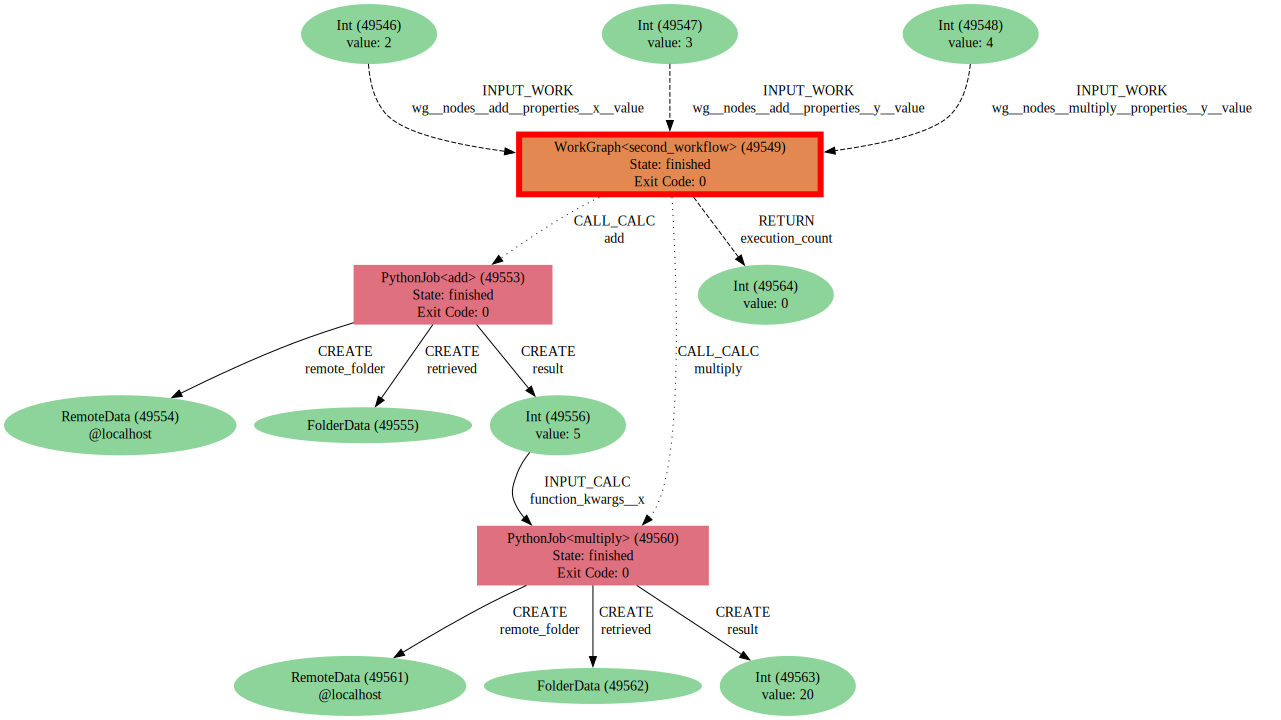

In [23]:
from aiida_workgraph.utils import generate_node_graph

#------------------------- Submit the calculation -------------------
# For real applications, one can pass metadata to the scheduler to activate the conda environment
metadata = {
    "options": {
        # 'custom_scheduler_commands' : 'module load anaconda\nconda activate py3.11\n',
        'custom_scheduler_commands' : '',
    }
}

wg.submit(inputs = {"add": {"x": 2, "y": 3,
                            "computer": "localhost",
                            "metadata": metadata},
                    "multiply": {"y": 4,
                                 "computer": "localhost",
                                 "metadata": metadata}},
          wait=True)
#------------------------- Print the output -------------------------
print("\nResult of multiply is {} \n\n".format(wg.nodes["multiply"].outputs['result'].value))
#------------------------- Generate node graph -------------------
generate_node_graph(wg.pk)

### Use parent folder
The parent_folder parameter allows a node to access the output files of a parent node. This feature is particularly useful when you want to reuse data generated by a previous computation in subsequent computations. In the following example, the multiply node uses the `result.txt` file created by the add node.

By default, the content of the parent folder is symlinked to the working directory. In the function, you can access the parent folder using the relative path. For example, `./parent_folder/result.txt`.

In [24]:
from aiida_workgraph import WorkGraph, node

# define add node
@node()
def add(x, y):
    z = x + y
    with open("result.txt", "w") as f:
        f.write(str(z))

# define multiply node
@node()
def multiply(x, y):
    with open("parent_folder/result.txt", "r") as f:
        z = int(f.read())
    return x*y + z

wg = WorkGraph("third_workflow")
wg.nodes.new(add, name="add", run_remotely=True)
wg.nodes.new(multiply, name="multiply",
             parent_folder=wg.nodes["add"].outputs["remote_folder"],
             run_remotely=True,
             )

wg.to_html()


Submit the calculation

In [25]:
#------------------------- Submit the calculation -------------------
wg.submit(inputs = {"add": {"x": 2, "y": 3, "computer": "localhost"},
                    "multiply": {"x": 3, "y": 4, "computer": "localhost"}},
          wait=True)
print("\nResult of multiply is {} \n\n".format(wg.nodes["multiply"].outputs['result'].value))

WorkGraph node created, PK: 49569

Result of multiply is uuid: cfa33bdc-aac0-4f1a-8590-aa34e9395dfb (pk: 49583) value: 17 




## CalcJob and WorkChain
AiiDA also provide builtin `CalcJob` to run a calculation on a remote computer. AiiDA community also provides a lot of well-written `calcfunction` and `WorkChain`. One can use these AiiDA component direclty in the WorkGraph. The inputs and outputs of the node is automatically generated based on the input and output port of the AiiDA component.

Here is an example of using the `ArithmeticAddCalculation` Calcjob inside the workgraph.

In [26]:
from aiida_workgraph import WorkGraph
from aiida.calculations.arithmetic.add import ArithmeticAddCalculation
from aiida.orm import Int, load_code

code = load_code("add@localhost")

wg = WorkGraph("test_add_multiply")
add1 = wg.nodes.new(ArithmeticAddCalculation, name="add1", x=Int(2), y=Int(3), code=code)
add2 = wg.nodes.new(ArithmeticAddCalculation, name="add2", y=Int(3), code=code)
wg.links.new(wg.nodes["add1"].outputs["sum"], wg.nodes["add2"].inputs["x"])
wg.to_html()


Submit the workgraph and wait for the result.

In [27]:
wg.submit(wait=True)
print('Result of node add1: {}'.format(wg.nodes["add2"].outputs["sum"].value))

WorkGraph node created, PK: 49588
Result of node add1: uuid: cd4e4a7f-d2e6-4eb6-922a-cf10118af8b0 (pk: 49596) value: 8


/home/xing/miniconda3/envs/aiida/lib/python3.11/site-packages/aiida/orm/nodes/data/code/legacy.py:172: AiidaDeprecationWarning: `Code.get_description` method is deprecated, use the `description` property instead. (this will be removed in v3)
  warn_deprecation(


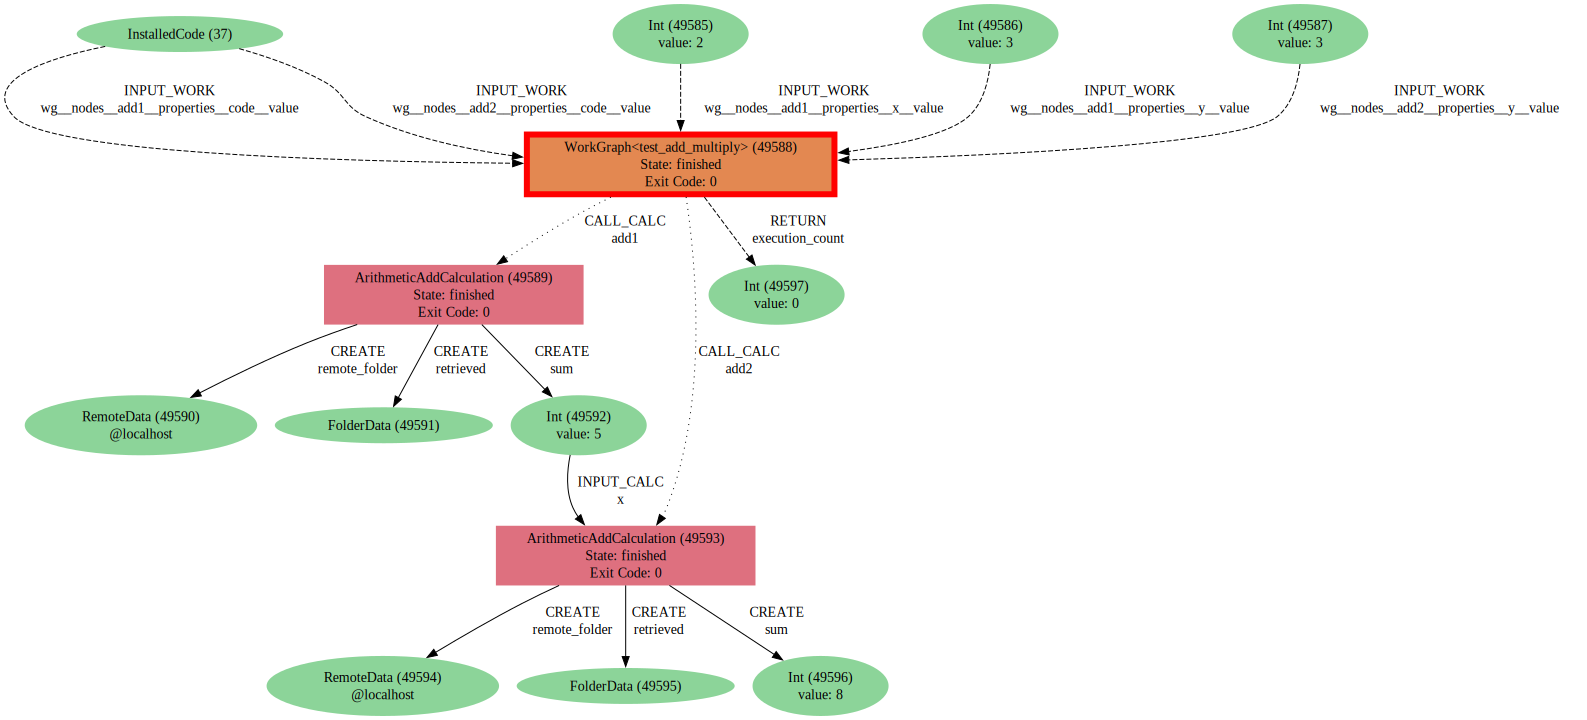

In [28]:
from aiida_workgraph.utils import generate_node_graph

generate_node_graph(wg.pk)

## Graph builder
A `WorkGraph` is a group of nodes. One can treat a `WorkGraph` as a single node, and expose the inputs and outputs of the `WorkGraph`. This allow you to write:

- nested workflows
- dynamic workflow based on the input values. For example, if you want to use `if` and `for` to create the nodes, or repeat a calculation until it converges.

The `Graph Builder` allow user to create a dynamic workflow based on the input value, as well as nested workflows. Here is an example of nested workflow:

In [29]:
from aiida_workgraph import WorkGraph, node

# define add node
@node.calcfunction()
def add(x, y):
    return x + y

# define multiply node
@node.calcfunction()
def multiply(x, y):
    return x*y


# use node.graph_builder decorator, expose the output of "multiply" node
# as the output of the `WorkGraph`.
@node.graph_builder(outputs = [["multiply.result", "result"]])
def add_multiply(x, y, z):
    # Create a WorkGraph
    wg = WorkGraph()
    wg.nodes.new(add, name="add", x=x, y=y)
    wg.nodes.new(multiply, name="multiply", x=z)
    wg.links.new(wg.nodes["add"].outputs["result"], wg.nodes["multiply"].inputs["y"])
    # don't forget to return the `wg`
    return wg

Use this graph builder inside a `WorkGraph`:

In [30]:

from aiida_workgraph import WorkGraph
from aiida.orm import Int

wg = WorkGraph("test_graph_build")
# create a node using the graph builder
add_multiply1 = wg.nodes.new(add_multiply, x=Int(2), y=Int(3), z=Int(4))
add_multiply2 = wg.nodes.new(add_multiply, x=Int(2), y=Int(3))
# link the output of int node to the input of add node
wg.links.new(add_multiply1.outputs["result"], add_multiply2.inputs["z"])
wg.submit(wait=True)
print("Worktree state: ", wg.state)

WorkGraph node created, PK: 49603
Worktree state:  FINISHED


Get the result of the nodes:

In [31]:
print('Result of node add_multiply1: {}'.format(add_multiply1.outputs["result"].value))

Result of node add_multiply1: uuid: 081449ab-3680-45ee-ab04-e972d936432e (pk: 49608) value: 20


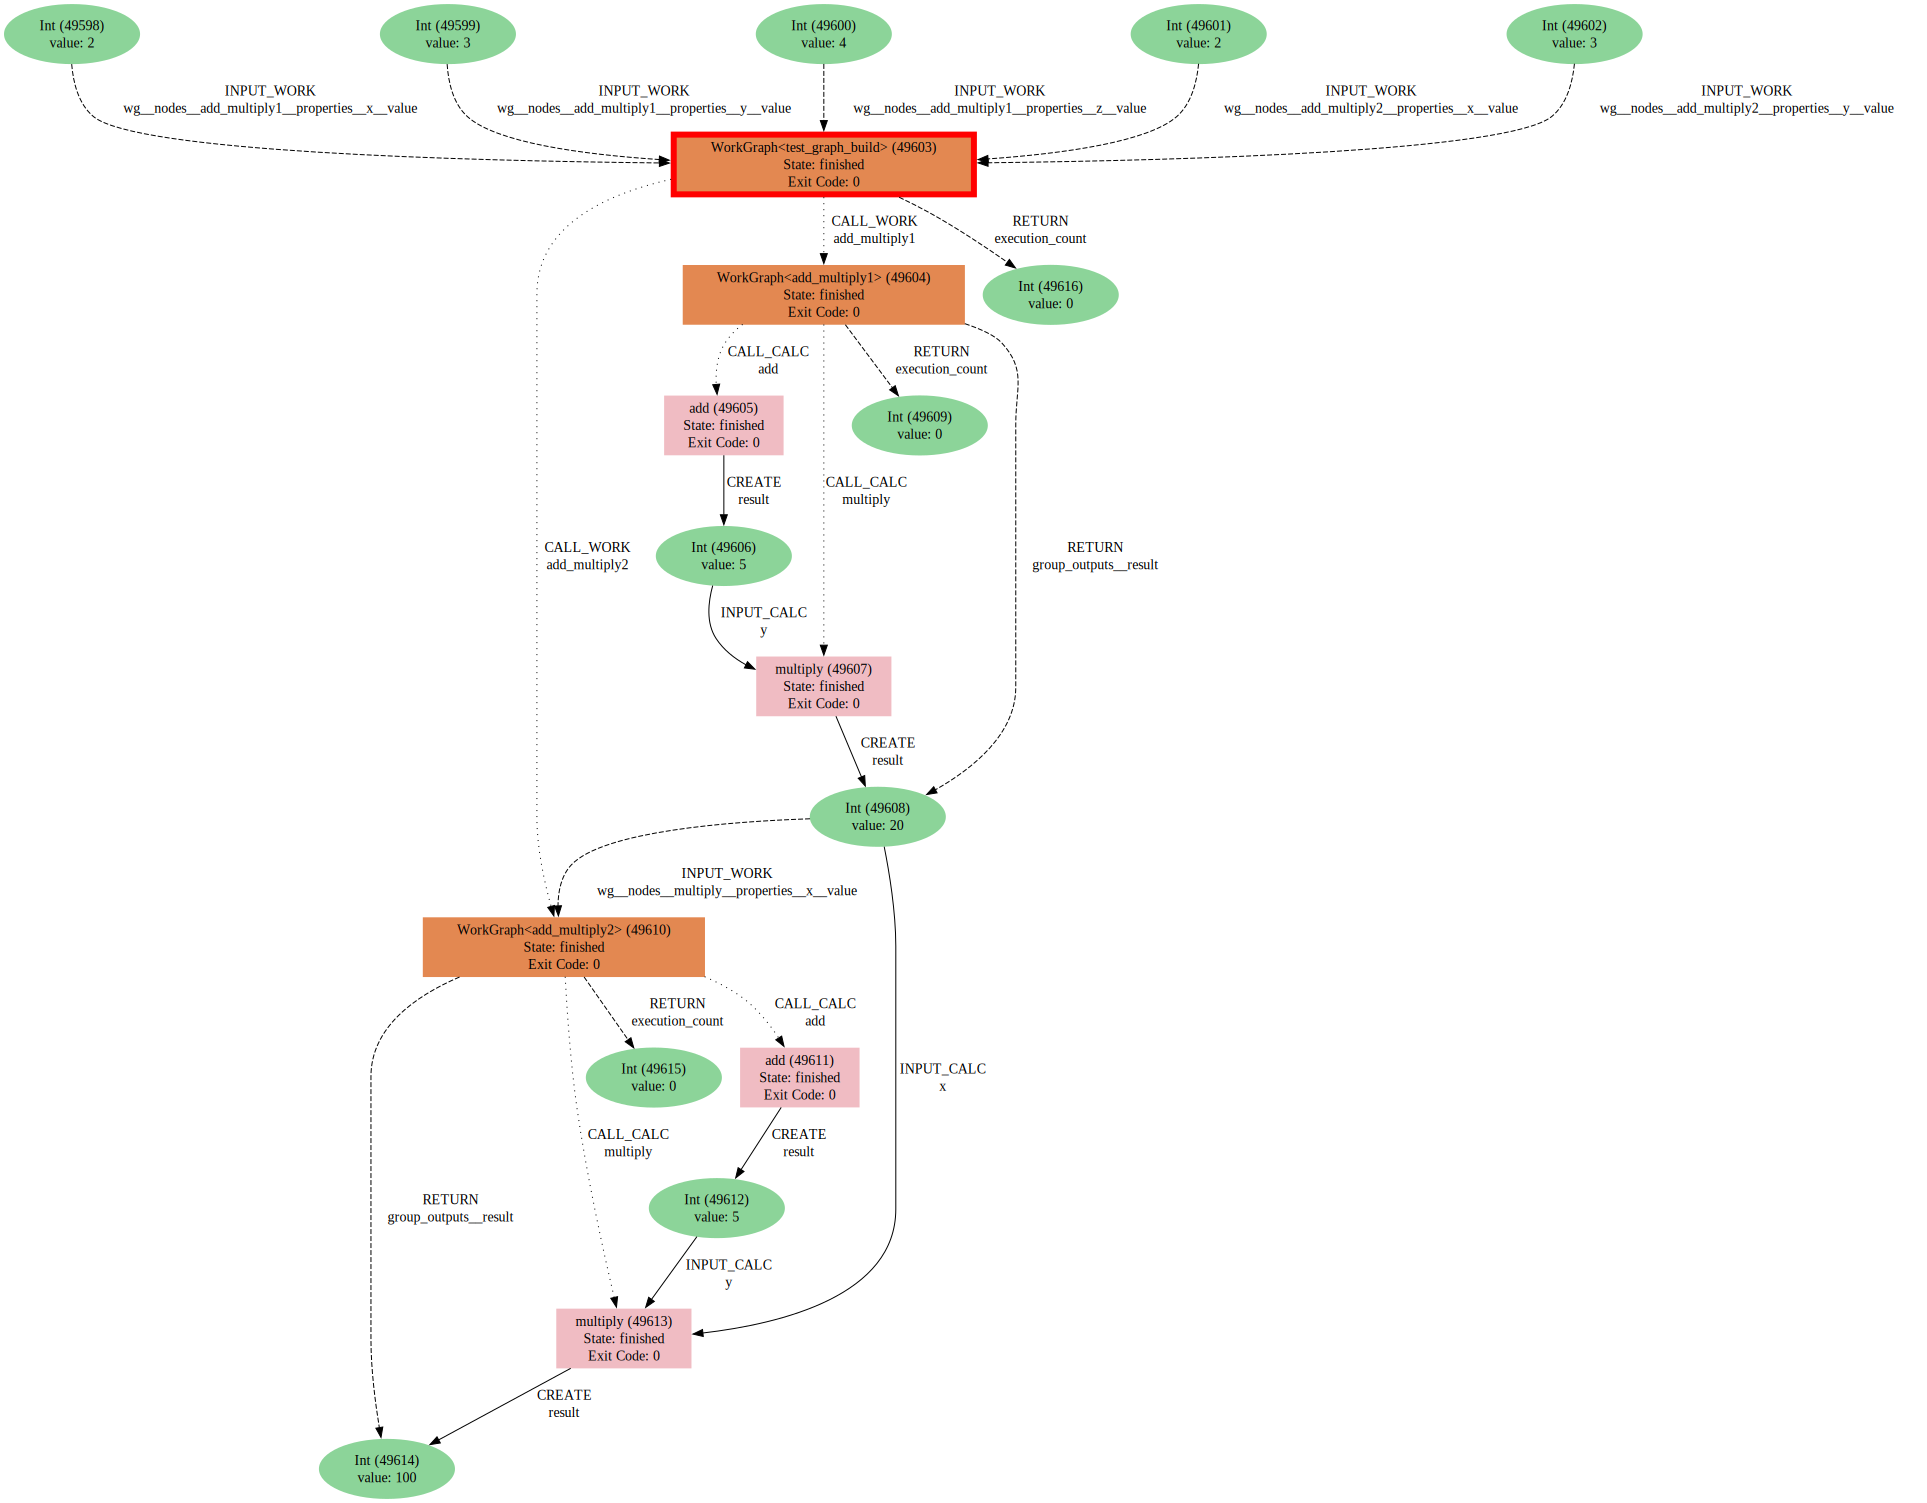

In [32]:
generate_node_graph(wg.pk)

### Start the web server
Worktree also provides a web GUI, where you can view and manage the workgraph. Open a terminal, and run:
```
workgraph web start
```
Then visit the page http://127.0.0.1:8000/workgraph, you can view the workgraph later from here. You should find all the submited workgraph, e.g., the `first_workflow` Worktree. Please click the pk and view the workgraph.

## What's Next

|        |                                         |
|---------------|----------------------------------------------------|
| [Concepts](concept/index.rst)                          | A brief introduction of WorkGraph’s main concepts.  |
| [Tutorials](tutorial/index.rst)                        | Real-world examples in computational materials science and more.                     |
| [HowTo](howto/index.rst)                              | Advanced topics and tips, e.g flow control using `if`, `for`, `while` and `context`.    |